# Open Street Map network partitioning
---

## Imports

In [128]:
import networkx as nx
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
from networkx.algorithms import community
import community as louvain
import matplotlib.cm as cm
import matplotlib.colors as mpcol
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
from operator import itemgetter
from haversine import haversine, Unit
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import math
from itertools import islice

%matplotlib inline

In [129]:
ox.config(data_folder='data', logs_folder='logs', 
          imgs_folder='imgs', cache_folder='cache', 
          use_cache=True, log_file=True, log_console=True)

# Download the data - write to pickle

In [130]:
#G_drive = ox.graph_from_place('Greater Manchester, UK', network_type='drive', simplify=True, which_result=2)
#G_drive = ox.project_graph(G_drive)

In [131]:
#nx.write_gpickle(G_drive, "pickle/OSM_street_network.gpickle")

In [132]:
G_drive = nx.read_gpickle("pickle/OSM_street_network.gpickle")

In [133]:
G_drive

## Undirected network

In [134]:
def undirected_network(G):
    G_simple = nx.Graph()
    for i,j,data in G.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G_simple.has_edge(i,j):
            G_simple[i][j]['weight'] += w
        else:
            G_simple.add_edge(i,j,weight=w)
    return G_simple

In [135]:
G_simple = undirected_network(G_drive)

## Community detection - this section can be ignored

In [136]:
def find_communities(G):
    start_time = time.time()
    partition = louvain.best_partition(G)
    part_dict = {}
    values = []
    for node in G.nodes():
        values.append(partition.get(node))
        part_dict.update({node:partition.get(node)})
    communities_louvain= max(values)+1
    end_time = time.time()
    mod_louvain = louvain.modularity(partition,G_simple)
    print('Communities found using the Louvain algorithm: {} \nModularity: {} \nTime for finding the communities: {} s'.format(communities_louvain, mod_louvain,round((end_time-start_time),3)))
    return part_dict

In [137]:
part_dict = find_communities(G_simple)

Communities found using the Louvain algorithm: 202 
Modularity: 0.9855888825155771 
Time for finding the communities: 61.689 s


In [138]:
#Set the node attributes ussing the partition dictionary.
nx.set_node_attributes(G_drive, part_dict, 'community')

# Get a list of len(nodes) with their corresponding community
communities = [(G_drive.nodes()[i]['community']) for i in G_drive.nodes()]

In [139]:
#List of color
Color_barragan = ['#E1CF3F','#F47757','#FD4581','#97577C','#BDA7A9','#E1CF3F','#F47757','#FD4581',
                 '#e44623','#e45a6a','#c9d3e6','#7d513d',
                 '#e65949','#d6b240','#382a29','#d8d4c9',
                 '#e4cc34','#ccb42c','#bc8ca4','#3c84c4',
                 '#dd4d3d','#52172f','#63494a','#e2d5d3',
                 '#f7abcc','#e085a1','#943d39','#2d1d19']
#Create the color map
Barragan = mpcol.ListedColormap(Color_barragan, name='Barragan')

In [140]:
com = [x[1] for x in G_drive.nodes(data='community')]
norm = mpcol.Normalize(vmin=min(com), vmax=max(com), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=Barragan)
nc=[mapper.to_rgba(x) for x in com]

## Plot over the neighborhoods.
Plot the network communities over the administrative partitions of the area.

In [141]:
gdf = ox.geocode_to_gdf(query=['Manchester, UK', 'Rochdale, UK', 'Bury, Greater Manchester, UK', 
                                  'Salford, UK', 'Stockport, UK',
                                 'Trafford, UK', 'Oldham, UK', 'Tameside, UK', 'Bolton, Greater Manchester, UK', 'Wigan, UK'])


In [142]:
gdf

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((-2.31992 53.41161, -2.31847 53.40999...",53.544592,53.340104,-2.146829,-2.319918,256898587,relation,146656,53.479489,-2.245115,"Manchester, Greater Manchester, North West Eng...",boundary,administrative,0.791719
1,"POLYGON ((-2.28259 53.58634, -2.28255 53.58627...",53.685719,53.529027,-2.026870,-2.282585,256898159,relation,146926,53.615366,-2.155756,"Rochdale, Greater Manchester, North West Engla...",boundary,administrative,0.609456
2,"POLYGON ((-2.38341 53.62558, -2.38279 53.62523...",53.667065,53.512021,-2.234102,-2.383409,256898029,relation,146927,53.592754,-2.297283,"Bury, Greater Manchester, North West England, ...",boundary,administrative,0.752337
3,"POLYGON ((-2.48973 53.46014, -2.48972 53.45984...",53.542139,53.415892,-2.245106,-2.489730,256898366,relation,146657,53.487746,-2.289192,"Salford, Greater Manchester, North West Englan...",boundary,administrative,0.609158
4,"POLYGON ((-2.24683 53.39604, -2.24621 53.39567...",53.454921,53.327315,-1.992330,-2.246828,256913901,relation,146658,53.407901,-2.160243,"Stockport, Greater Manchester, North West Engl...",boundary,administrative,0.623540
5,"POLYGON ((-2.47845 53.39622, -2.47804 53.39570...",53.480386,53.357411,-2.253023,-2.478454,256897937,relation,146675,53.418936,-2.359297,"Trafford, Greater Manchester, North West Engla...",boundary,administrative,0.583688
6,"POLYGON ((-2.18589 53.52903, -2.18546 53.52902...",53.624229,53.491139,-1.909622,-2.185894,256898927,relation,146925,53.541580,-2.114783,"Oldham, Greater Manchester, North West England...",boundary,administrative,0.562153
7,"POLYGON ((-2.16966 53.48677, -2.16954 53.48606...",53.531361,53.425936,-1.963386,-2.169665,256898781,relation,146655,53.478645,-2.077021,"Tameside, Greater Manchester, North West Engla...",boundary,administrative,0.567899
8,"POLYGON ((-2.62862 53.59052, -2.62861 53.59044...",53.646029,53.522866,-2.337040,-2.628616,305762368,relation,146937,53.578286,-2.430037,"Bolton, Greater Manchester, North West England...",boundary,administrative,0.838700
9,"POLYGON ((-2.73052 53.52058, -2.72985 53.51995...",53.608311,53.446057,-2.414582,-2.730521,256913908,relation,146938,53.545719,-2.626462,"Wigan, Greater Manchester, North West England,...",boundary,administrative,0.636757


In [143]:
gdf = ox.project_gdf(gdf)

## Functions to make plot

Use the first axis (ax) to overlay the plots

In [144]:
fig, ax = ox.plot_graph(G_drive, node_color=nc, node_size=8, node_zorder=3, node_alpha=1, 
                        edge_linewidth=0.25, edge_color='lightblue',edge_alpha=1, figsize=(14,14),close=False, show=False)
plt.close()

In [145]:
geom = gdf['geometry'].tolist()
pol = [x for x in range(len(geom))]
norm = mpcol.Normalize(vmin=min(pol)+2, vmax=max(pol)+1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.gray)
colors=[mapper.to_rgba(x) for x in pol]

In [146]:
for geometry, color in zip(gdf['geometry'].tolist(), colors):
    patch = PolygonPatch(geometry, fc=color, ec='white', linewidth=2, alpha=0.7, zorder=-1)
    ax.add_patch(patch)

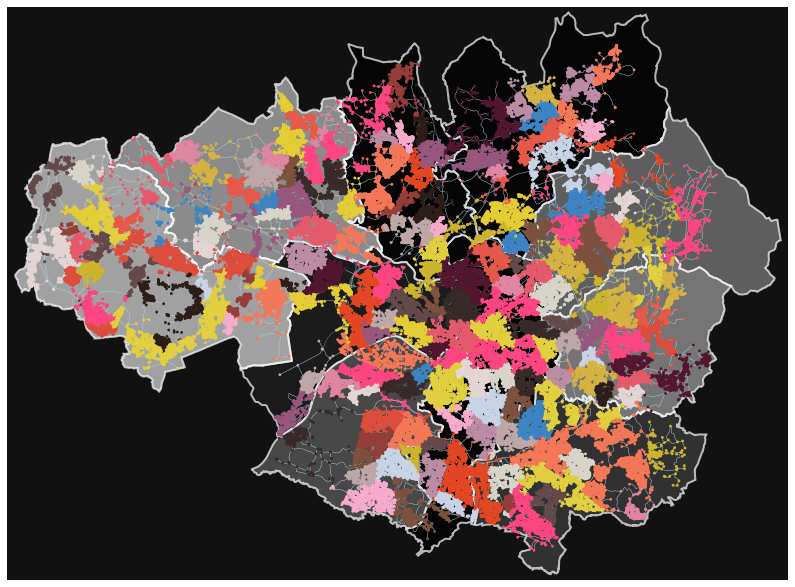

In [147]:
margin = 0.01
west, south, east, north = gdf.unary_union.bounds
margin_ns = (north - south) * margin
margin_ew = (east - west) * margin
ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))
fig

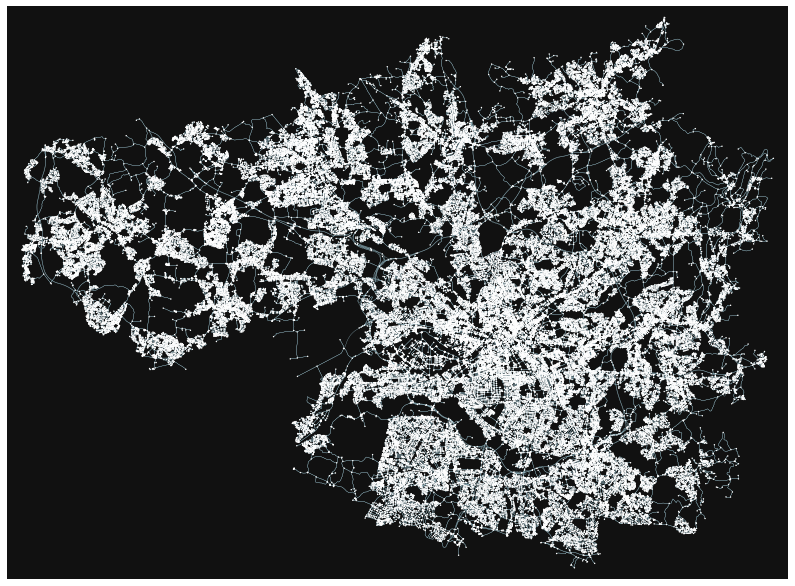

In [148]:
fig, ax = ox.plot_graph(G_drive, node_size=2, node_zorder=3, node_alpha=1, 
                        edge_linewidth=0.25, edge_color='lightblue',edge_alpha=1, figsize=(14,14),close=False, show=False)

# Partitioning the graph into geographical chunks

In [149]:
G = nx.Graph(G_drive)
G

In [150]:
list(G.nodes(data=True))[0]

(398721038,
 {'y': 5927330.199041799,
  'x': 529715.0012583488,
  'osmid': 398721038,
  'highway': nan,
  'ref': nan,
  'lon': -2.5520905,
  'lat': 53.4940952,
  'community': 197})

In [151]:
list(G.nodes(data=True))[0][1]

{'y': 5927330.199041799,
 'x': 529715.0012583488,
 'osmid': 398721038,
 'highway': nan,
 'ref': nan,
 'lon': -2.5520905,
 'lat': 53.4940952,
 'community': 197}

In [152]:
# get lat long
(list(G.nodes(data=True))[0][1]['lat'], list(G.nodes(data=True))[0][1]['lon'])

(53.4940952, -2.5520905)

In [456]:
# get tuple of x/y coordinates

locations = []

for node in G.nodes():
    locations.append(tuple([(G.nodes[node]['lat']), G.nodes[node]['lon']]))

In [457]:
locations

[(53.4940952, -2.5520905),
 (53.558678, -2.6370791),
 (53.4790114, -2.5414737),
 (53.3796376, -2.1336019),
 (53.3789169, -2.1342359),
 (53.3801994, -2.1333992),
 (53.3791322, -2.1342904),
 (53.3796981, -2.1337661),
 (53.4263233, -2.1325508),
 (53.3796465, -2.1337053),
 (53.3797828, -2.1336849),
 (53.4351757, -2.1631437),
 (53.3797235, -2.1335123),
 (53.3863382, -2.1422062),
 (53.3838284, -2.153236),
 (53.3840068, -2.153146),
 (53.3797528, -2.1335295),
 (53.383932, -2.1535577),
 (53.4842776, -2.6100584),
 (53.6633462, -2.0827481),
 (53.4868209, -2.6097837),
 (53.3839971, -2.1528472),
 (53.3838942, -2.1531025),
 (53.6634269, -2.0833748),
 (53.41737, -2.2882547),
 (53.4173873, -2.2878627),
 (53.4170356, -2.2871947),
 (53.4244995, -2.132355),
 (53.4784189, -2.5408986),
 (53.4167046, -2.2862783),
 (53.4779584, -2.5408424),
 (53.4162618, -2.2861194),
 (53.4007018, -2.1587743),
 (53.4157638, -2.2871731),
 (53.4160561, -2.2875593),
 (53.416396, -2.2877298),
 (53.620676, -2.1323043),
 (53.62116

In [458]:
# get min/max coordinates
min_x = min(locations,key=itemgetter(0))[0]
max_x = max(locations,key=itemgetter(0))[0]
min_y = min(locations,key=itemgetter(1))[1]
max_y = max(locations,key=itemgetter(1))[1]

In [459]:
min_x

53.3426582

In [460]:
max_x

53.6643887

In [461]:
min_y

-2.7171539

In [462]:
max_y

-1.9774292

In [463]:
# get corners of rectangle
sw = tuple([min_x, min_y])
nw = tuple([min_x, max_y])
ne = tuple([max_x, max_y])
se = tuple([max_x, min_y])

In [464]:
print(nw)
print(sw)
print(ne)
print(se)

(53.3426582, -1.9774292)
(53.3426582, -2.7171539)
(53.6643887, -1.9774292)
(53.6643887, -2.7171539)


In [465]:
# find length of sides
length = haversine(sw, nw, Unit.KILOMETERS)
print(length)
width = haversine(sw, se, Unit.KILOMETERS)
print(width)

49.107573959225896
35.774848761074324


In [466]:
length*width

1756.8160314145782

In [467]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1),
               np.linspace(p1[1], p2[1], parts+1))

In [468]:
# list(getEquidistantPoints((nw), (sw), 5))

In [469]:
# list(getEquidistantPoints((sw), (se), 5))

In [470]:
y = list(getEquidistantPoints((nw), (sw), 5))
x = list(getEquidistantPoints((sw), (se), 5))

In [471]:
ys = [x[1] for x in y]

In [472]:
xs = [x[0] for x in x]

In [473]:
print(ys)
print(xs)

[-1.9774292, -2.12537414, -2.27331908, -2.4212640199999997, -2.56920896, -2.7171539]
[53.3426582, 53.407004300000004, 53.471350400000006, 53.5356965, 53.6000426, 53.6643887]


In [474]:
X, Y = np.meshgrid(xs, ys)
grid = zip(X, Y)

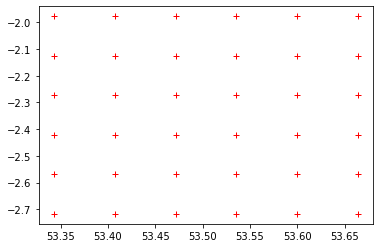

In [475]:
plt.plot(X, Y, marker='+', color='red', linestyle='none')

In [476]:
#X, Y = np.meshgrid(xs, ys)
#grid = zip(X, Y)

In [477]:
grid = []

for y in ys:
    for x in xs:
        grid.append(tuple([x,y]))

In [478]:
type(grid)

list

In [479]:
grid

[(53.3426582, -1.9774292),
 (53.407004300000004, -1.9774292),
 (53.471350400000006, -1.9774292),
 (53.5356965, -1.9774292),
 (53.6000426, -1.9774292),
 (53.6643887, -1.9774292),
 (53.3426582, -2.12537414),
 (53.407004300000004, -2.12537414),
 (53.471350400000006, -2.12537414),
 (53.5356965, -2.12537414),
 (53.6000426, -2.12537414),
 (53.6643887, -2.12537414),
 (53.3426582, -2.27331908),
 (53.407004300000004, -2.27331908),
 (53.471350400000006, -2.27331908),
 (53.5356965, -2.27331908),
 (53.6000426, -2.27331908),
 (53.6643887, -2.27331908),
 (53.3426582, -2.4212640199999997),
 (53.407004300000004, -2.4212640199999997),
 (53.471350400000006, -2.4212640199999997),
 (53.5356965, -2.4212640199999997),
 (53.6000426, -2.4212640199999997),
 (53.6643887, -2.4212640199999997),
 (53.3426582, -2.56920896),
 (53.407004300000004, -2.56920896),
 (53.471350400000006, -2.56920896),
 (53.5356965, -2.56920896),
 (53.6000426, -2.56920896),
 (53.6643887, -2.56920896),
 (53.3426582, -2.7171539),
 (53.407004

In [480]:
point = Point(0.5, 0.5)
polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
print(polygon.contains(point))

True


In [481]:
for i in grid:
    print(i)

(53.3426582, -1.9774292)
(53.407004300000004, -1.9774292)
(53.471350400000006, -1.9774292)
(53.5356965, -1.9774292)
(53.6000426, -1.9774292)
(53.6643887, -1.9774292)
(53.3426582, -2.12537414)
(53.407004300000004, -2.12537414)
(53.471350400000006, -2.12537414)
(53.5356965, -2.12537414)
(53.6000426, -2.12537414)
(53.6643887, -2.12537414)
(53.3426582, -2.27331908)
(53.407004300000004, -2.27331908)
(53.471350400000006, -2.27331908)
(53.5356965, -2.27331908)
(53.6000426, -2.27331908)
(53.6643887, -2.27331908)
(53.3426582, -2.4212640199999997)
(53.407004300000004, -2.4212640199999997)
(53.471350400000006, -2.4212640199999997)
(53.5356965, -2.4212640199999997)
(53.6000426, -2.4212640199999997)
(53.6643887, -2.4212640199999997)
(53.3426582, -2.56920896)
(53.407004300000004, -2.56920896)
(53.471350400000006, -2.56920896)
(53.5356965, -2.56920896)
(53.6000426, -2.56920896)
(53.6643887, -2.56920896)
(53.3426582, -2.7171539)
(53.407004300000004, -2.7171539)
(53.471350400000006, -2.7171539)
(53.535

In [482]:
x_square = (max_x - min_x)/10
x_square

0.032173050000000106

In [483]:
y_square = (max_y - min_y)/10
y_square

0.07397247

In [484]:
df = pd.DataFrame()

x_square = (max_x - min_x)/10
y_square = (max_y - min_y)/10
#square_side = 5
#x_min = df['X[mm]'].min()
#y_min = df['Y[mm]'].min()

def label_point(x, y):
    # Double forward slash is integer (round down) division
    # Add 1 here if you really want 1-based indexing
    x_label = (x - min_x) // (x_square)

    y_label = chr(ord('A') + int((y - min_y) // y_square))
    
    return f'{y_label}{x_label}'

In [485]:
xx = []
for i in locations:
    xx.append(i[0])
    
yy = []
for i in locations:
    yy.append(i[1])

In [486]:
df['x'] = xx
df['y'] = yy

In [487]:
chr(ord('A') + int((max_y - min_y) // y_square))

'K'

In [488]:
df['label'] = df[['x', 'y']].apply(lambda coord: label_point(*coord), axis=1)

In [489]:
df['label'].value_counts()

G4.0    3246
G3.0    2815
D7.0    2624
H8.0    2570
I4.0    2487
        ... 
D1.0      11
E9.0       5
B8.0       4
K7.0       1
J0.0       1
Name: label, Length: 84, dtype: int64

In [490]:
df

,x,y,label
0,53.494095,-2.552090,C4.0
1,53.558678,-2.637079,B6.0
2,53.479011,-2.541474,C4.0
3,53.379638,-2.133602,H1.0
4,53.378917,-2.134236,H1.0
...,...,...,...
96248,53.369216,-2.327129,F0.0
96249,53.379133,-2.134148,H1.0
96250,53.523432,-2.142255,H5.0
96251,53.379268,-2.134107,H1.0


In [491]:
res = dict(zip(list(G.nodes()), df['label']))

In [492]:
res

{398721038: 'C4.0',
 173539348: 'B6.0',
 364904472: 'C4.0',
 2269904920: 'H1.0',
 2269904922: 'H1.0',
 2269904925: 'H1.0',
 2269904929: 'H1.0',
 2269904933: 'H1.0',
 371982379: 'H2.0',
 2269904947: 'H1.0',
 2269904954: 'H1.0',
 373555260: 'H2.0',
 2269904964: 'H1.0',
 393740358: 'H1.0',
 393740359: 'H1.0',
 393740360: 'H1.0',
 2269904966: 'H1.0',
 393740365: 'H1.0',
 258998351: 'B4.0',
 1913126992: 'I9.0',
 258998353: 'B4.0',
 393740368: 'H1.0',
 393740369: 'H1.0',
 1913126996: 'I9.0',
 82575449: 'F2.0',
 82575450: 'F2.0',
 82575455: 'F2.0',
 371982433: 'H2.0',
 364904547: 'C4.0',
 82575459: 'F2.0',
 364904549: 'C4.0',
 82575462: 'F2.0',
 2470183016: 'H1.0',
 82575469: 'F2.0',
 82575472: 'F2.0',
 82575475: 'F2.0',
 1885339768: 'H8.0',
 1885339769: 'H8.0',
 2470183043: 'H1.0',
 2470183044: 'H2.0',
 33030276: 'E7.0',
 2808610962: 'F3.0',
 1746665638: 'I4.0',
 1746665639: 'I4.0',
 840433843: 'G3.0',
 6432499277: 'E8.0',
 840433846: 'G3.0',
 6432499278: 'E8.0',
 840433850: 'G3.0',
 3819439

In [493]:
nx.set_node_attributes(G, res, "sub_graph")

In [494]:
locations = dict(zip(list(G.nodes()), locations))
nx.set_node_attributes(G, locations, 'pos')

In [495]:
list(G.nodes(data=True))[0]

(398721038,
 {'y': 5927330.199041799,
  'x': 529715.0012583488,
  'osmid': 398721038,
  'highway': nan,
  'ref': nan,
  'lon': -2.5520905,
  'lat': 53.4940952,
  'community': 197,
  'pos': (53.4940952, -2.5520905),
  'sub_graph': 'C4.0'})

In [496]:
list(G.nodes(data=True))[10]

(2269904954,
 {'y': 5914869.262966493,
  'x': 557626.6518414832,
  'osmid': 2269904954,
  'highway': nan,
  'ref': nan,
  'lon': -2.1336849,
  'lat': 53.3797828,
  'community': 3,
  'pos': (53.3797828, -2.1336849),
  'sub_graph': 'H1.0'})

In [497]:
grid_refs = sorted(df['label'].unique())

In [498]:
len(grid_refs)

84

In [499]:
from itertools import groupby

# Sort the nodes by their role (this is required for the groupby to work)
sorted_by_role = sorted(G.nodes(data=True), key=lambda node_data: node_data[1]["sub_graph"])
# Group objects with same role together
grouped = groupby(sorted_by_role, key=lambda node_data: node_data[1]["sub_graph"])

subgraphs = dict()
for key, group in grouped:
     nodes_in_group, _ = zip(*list(group))  # We don't care about the data here, only the node names
     subgraphs[key] = G.subgraph(nodes_in_group)

In [500]:
subgraphs

{'A4.0': <networkx.classes.graph.Graph at 0x262eedb20a0>,
 'A5.0': <networkx.classes.graph.Graph at 0x262977ebdf0>,
 'A6.0': <networkx.classes.graph.Graph at 0x262efa86790>,
 'A7.0': <networkx.classes.graph.Graph at 0x262eeddf4c0>,
 'B3.0': <networkx.classes.graph.Graph at 0x262eede0df0>,
 'B4.0': <networkx.classes.graph.Graph at 0x262eede0c70>,
 'B5.0': <networkx.classes.graph.Graph at 0x26305d24070>,
 'B6.0': <networkx.classes.graph.Graph at 0x26305d24130>,
 'B7.0': <networkx.classes.graph.Graph at 0x26305d24670>,
 'B8.0': <networkx.classes.graph.Graph at 0x26305d245b0>,
 'C3.0': <networkx.classes.graph.Graph at 0x262eeaf1070>,
 'C4.0': <networkx.classes.graph.Graph at 0x262eec915e0>,
 'C5.0': <networkx.classes.graph.Graph at 0x262eedbab20>,
 'C6.0': <networkx.classes.graph.Graph at 0x262f39f6b50>,
 'C7.0': <networkx.classes.graph.Graph at 0x26305d08eb0>,
 'C8.0': <networkx.classes.graph.Graph at 0x26305d08e20>,
 'D1.0': <networkx.classes.graph.Graph at 0x26305d08b50>,
 'D2.0': <netw

In [501]:
list(subgraphs['A4.0'].nodes(data=True))

[(381947904,
  {'y': 5927765.067418813,
   'x': 523491.9538451711,
   'osmid': 381947904,
   'highway': nan,
   'ref': nan,
   'lon': -2.6458589,
   'lat': 53.4983187,
   'community': 18,
   'pos': (53.4983187, -2.6458589),
   'sub_graph': 'A4.0'}),
 (380217863,
  {'y': 5926637.085270507,
   'x': 523445.3387002462,
   'osmid': 380217863,
   'highway': nan,
   'ref': nan,
   'lon': -2.6466459,
   'lat': 53.4881819,
   'community': 149,
   'pos': (53.4881819, -2.6466459),
   'sub_graph': 'A4.0'}),
 (380336137,
  {'y': 5927733.139872337,
   'x': 523047.05217795295,
   'osmid': 380336137,
   'highway': nan,
   'ref': nan,
   'lon': -2.652568,
   'lat': 53.4980514,
   'community': 18,
   'pos': (53.4980514, -2.652568),
   'sub_graph': 'A4.0'}),
 (380286988,
  {'y': 5927035.677167976,
   'x': 523421.7538002482,
   'osmid': 380286988,
   'highway': nan,
   'ref': nan,
   'lon': -2.6469716,
   'lat': 53.4917657,
   'community': 18,
   'pos': (53.4917657, -2.6469716),
   'sub_graph': 'A4.0'}),


In [502]:
list(subgraphs['A4.0'].nodes(data=True))[0][1]['pos']
type(list(subgraphs['A4.0'].nodes(data=True))[0][1]['pos'])

tuple

In [503]:
pos=nx.get_node_attributes(subgraphs['A4.0'],'pos')

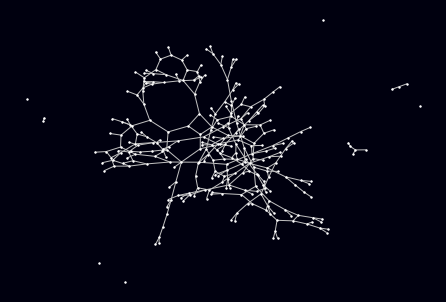

In [504]:
fig = plt.figure()
nx.draw(subgraphs['A4.0'], node_size=2, node_color='white', edge_color='silver')
fig.set_facecolor("#00000F")

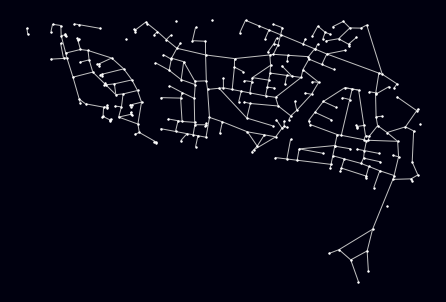

In [505]:
fig = plt.figure()
nx.draw(subgraphs['A4.0'], pos, node_size=2, node_color='white', edge_color='silver')
fig.set_facecolor("#00000F")

In [506]:
all_grid_refs = []

for i in range(11):
    for j in range(10):
        x = j
        y =  chr(ord('A') + int(i))
        all_grid_refs.append(f'{y}{x}.0')

In [507]:
all_grid_refs

['A0.0',
 'A1.0',
 'A2.0',
 'A3.0',
 'A4.0',
 'A5.0',
 'A6.0',
 'A7.0',
 'A8.0',
 'A9.0',
 'B0.0',
 'B1.0',
 'B2.0',
 'B3.0',
 'B4.0',
 'B5.0',
 'B6.0',
 'B7.0',
 'B8.0',
 'B9.0',
 'C0.0',
 'C1.0',
 'C2.0',
 'C3.0',
 'C4.0',
 'C5.0',
 'C6.0',
 'C7.0',
 'C8.0',
 'C9.0',
 'D0.0',
 'D1.0',
 'D2.0',
 'D3.0',
 'D4.0',
 'D5.0',
 'D6.0',
 'D7.0',
 'D8.0',
 'D9.0',
 'E0.0',
 'E1.0',
 'E2.0',
 'E3.0',
 'E4.0',
 'E5.0',
 'E6.0',
 'E7.0',
 'E8.0',
 'E9.0',
 'F0.0',
 'F1.0',
 'F2.0',
 'F3.0',
 'F4.0',
 'F5.0',
 'F6.0',
 'F7.0',
 'F8.0',
 'F9.0',
 'G0.0',
 'G1.0',
 'G2.0',
 'G3.0',
 'G4.0',
 'G5.0',
 'G6.0',
 'G7.0',
 'G8.0',
 'G9.0',
 'H0.0',
 'H1.0',
 'H2.0',
 'H3.0',
 'H4.0',
 'H5.0',
 'H6.0',
 'H7.0',
 'H8.0',
 'H9.0',
 'I0.0',
 'I1.0',
 'I2.0',
 'I3.0',
 'I4.0',
 'I5.0',
 'I6.0',
 'I7.0',
 'I8.0',
 'I9.0',
 'J0.0',
 'J1.0',
 'J2.0',
 'J3.0',
 'J4.0',
 'J5.0',
 'J6.0',
 'J7.0',
 'J8.0',
 'J9.0',
 'K0.0',
 'K1.0',
 'K2.0',
 'K3.0',
 'K4.0',
 'K5.0',
 'K6.0',
 'K7.0',
 'K8.0',
 'K9.0']

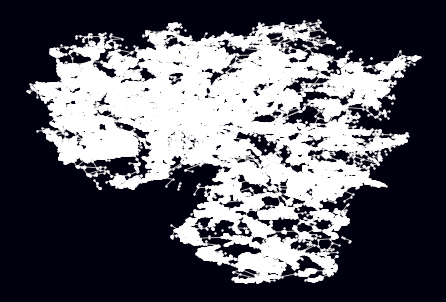

In [509]:
fig = plt.figure()
for i in grid_refs:
    pos=nx.get_node_attributes(subgraphs[i],'pos')
    nx.draw(subgraphs[i], pos, node_size=2, node_color='white', edge_color='silver')
fig.set_facecolor("#00000F")

In [510]:
gg = nx.Graph()

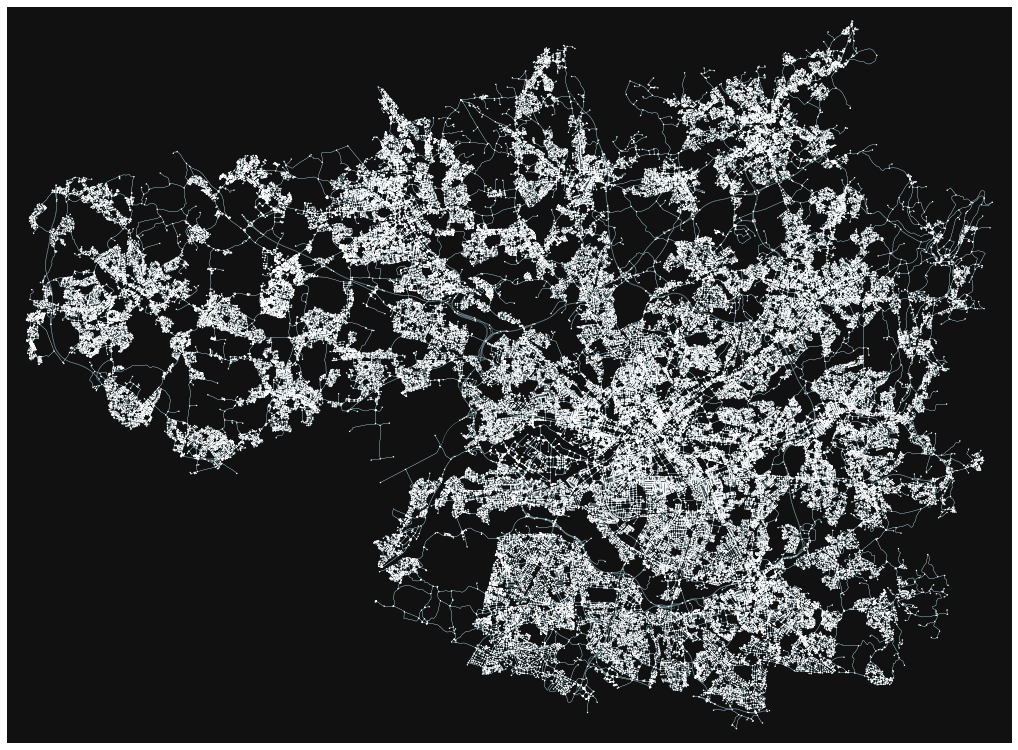

In [454]:
fig, ax = ox.plot_graph(G_drive, node_size=2, node_zorder=3, node_alpha=1, 
                        edge_linewidth=0.25, edge_color='lightblue',edge_alpha=1, figsize=(18,18),close=False, show=False)

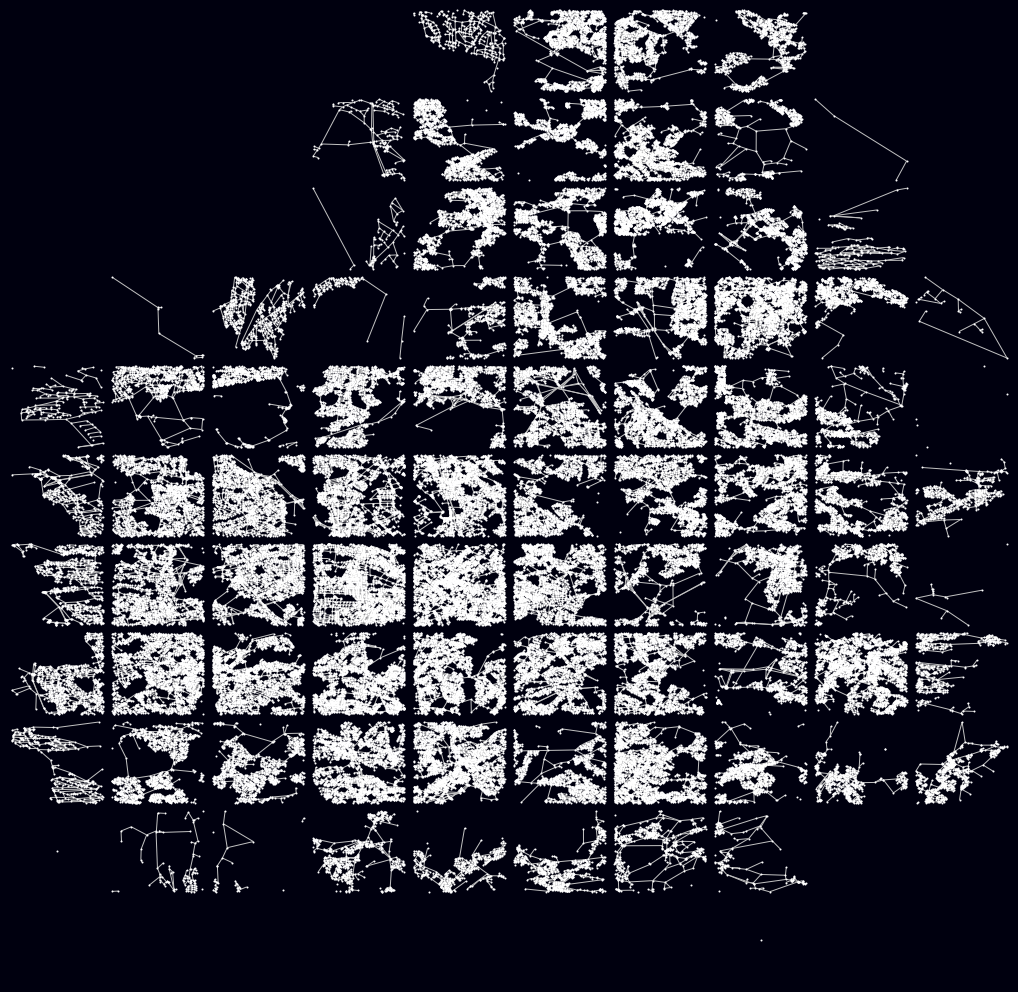

In [511]:
fig, axes = plt.subplots(nrows=11, ncols=10, figsize=(18,18))
fig.subplots_adjust(hspace =.001, wspace=.001)
ax = axes.flatten()
i=0

for i,j in enumerate(all_grid_refs):
    if j in grid_refs:
        pos = nx.get_node_attributes(subgraphs[j],'pos')
        nx.draw(subgraphs[j], pos, node_size=1, node_color='white', edge_color='silver', ax=ax[i])
        ax[i].set_axis_off()
        i+=1
        fig.set_facecolor("#00000F")
    else:
        nx.draw(gg, ax=ax[i])
        ax[i].set_axis_off()
        fig.set_facecolor("#00000F")
        i+=1

plt.show()

In [349]:
all_grid_refs[4] in grid_refs

True

In [344]:
grid_refs

['A4.0',
 'A5.0',
 'A6.0',
 'A7.0',
 'B3.0',
 'B4.0',
 'B5.0',
 'B6.0',
 'B7.0',
 'B8.0',
 'C3.0',
 'C4.0',
 'C5.0',
 'C6.0',
 'C7.0',
 'C8.0',
 'D1.0',
 'D2.0',
 'D3.0',
 'D4.0',
 'D5.0',
 'D6.0',
 'D7.0',
 'D8.0',
 'D9.0',
 'E0.0',
 'E1.0',
 'E2.0',
 'E3.0',
 'E4.0',
 'E5.0',
 'E6.0',
 'E7.0',
 'E8.0',
 'E9.0',
 'F0.0',
 'F1.0',
 'F2.0',
 'F3.0',
 'F4.0',
 'F5.0',
 'F6.0',
 'F7.0',
 'F8.0',
 'F9.0',
 'G0.0',
 'G1.0',
 'G2.0',
 'G3.0',
 'G4.0',
 'G5.0',
 'G6.0',
 'G7.0',
 'G8.0',
 'G9.0',
 'H0.0',
 'H1.0',
 'H2.0',
 'H3.0',
 'H4.0',
 'H5.0',
 'H6.0',
 'H7.0',
 'H8.0',
 'H9.0',
 'I0.0',
 'I1.0',
 'I2.0',
 'I3.0',
 'I4.0',
 'I5.0',
 'I6.0',
 'I7.0',
 'I8.0',
 'I9.0',
 'J0.0',
 'J1.0',
 'J2.0',
 'J3.0',
 'J4.0',
 'J5.0',
 'J6.0',
 'J7.0',
 'K7.0']

In [72]:
A = nx.adjacency_matrix(subgraphs['A4.0'])

In [73]:
print(A.todense())

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [380]:
'A4.0' in grid_refs

True

In [127]:
len(G.nodes())

96253

In [379]:
j

'K9.0'

In [ ]:
for node in G.nodes():
    for attribute in G.node[node]['attributes']:
        if attribute in question:
            setOfUsers.append(node) 